In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

plt.style.use('ggplot')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

In [2]:
stock_prices = pd.read_csv('stock_prices.csv', parse_dates=True, index_col='Date')
day_10_returns = pd.read_csv('10_days_returns.csv', parse_dates=True, index_col='Date')
daily_log_returns = pd.read_csv('log_returns.csv', parse_dates=True, index_col='Date')

# 1. Данные

In [3]:
day_10_returns.head()

,AAL.L,BARC.L,BP.L,HSBA.L,LLOY.L,RBS.L,RDSA.L,RIO.L
Date,,,,,,,,
2009-07-14,-0.046112,0.033590,-0.033061,0.002551,-0.035911,-0.063063,-0.055305,-0.064180
2009-07-15,0.042874,0.084083,0.017569,0.061363,0.042934,0.011609,0.003324,0.034152
2009-07-16,0.026554,0.059934,0.025769,0.054224,0.036310,-0.016630,0.019411,0.026900
2009-07-17,0.109610,0.069516,0.059996,0.076118,0.021175,0.019244,0.049897,0.142706
2009-07-20,0.099232,0.057434,0.075673,0.111995,0.091039,0.085354,0.064516,0.163021


In [4]:
daily_log_returns.head()

,AAL.L,BARC.L,BP.L,HSBA.L,LLOY.L,RBS.L,RDSA.L,RIO.L
Date,,,,,,,,
2009-07-02,-0.059875,-0.004317,-0.018642,-0.018222,-0.035043,-0.038942,-0.033347,-0.058686
2009-07-03,-0.007269,0.027306,-0.003541,0.017240,0.023980,0.023082,-0.006671,-0.004432
2009-07-06,-0.050879,-0.014413,-0.026536,-0.005022,-0.020954,-0.029037,-0.020968,-0.072136
2009-07-07,-0.000614,0.011040,0.002354,-0.007432,-0.001501,-0.009601,-0.004110,0.018397
2009-07-08,-0.040118,-0.030875,-0.006003,-0.019484,-0.035316,-0.045646,-0.008270,-0.012843


# 2. Описание данных

- Цены закрытия акций выружены с Yahoo Finance.
- Ставки взяты с сайта ЦБ РФ.
- Кросс-валютный курс выгружен с сайта stooq.com, который берет информацию с Google Finance.

Выведим описательные статистики, skew, kurtosis и автокорреляцию по первому лагу арифметических 10-дневных доходностей акций.

In [5]:
from scipy.stats import skew
from scipy.stats import kurtosis

In [6]:
description = day_10_returns.describe()

colnames = list(day_10_returns.columns)
autocorrelation = []

for colname in colnames:
    autocorrelation.append(day_10_returns[colname].autocorr(lag = 1))
    
autocorr = pd.DataFrame([autocorrelation], columns = colnames, index=['autocorr'])
skews = pd.DataFrame([skew(day_10_returns, axis = 0).tolist()], columns = colnames, index=['skew'])
kurt = pd.DataFrame([kurtosis(day_10_returns, axis = 0).tolist()], columns = colnames, index=['kurtosis'])

description = description.append(autocorr)
description = description.append(skews)
description = description.append(kurt)

In [7]:
description

,AAL.L,BARC.L,BP.L,HSBA.L,LLOY.L,RBS.L,RDSA.L,RIO.L
count,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000
mean,0.004717,-0.001808,0.000201,0.002425,0.000081,-0.000907,0.005217,0.007601
std,0.064450,0.081176,0.059591,0.046345,0.091890,0.097494,0.040665,0.072307
min,-0.228152,-0.281701,-0.298195,-0.149308,-0.314556,-0.330485,-0.177725,-0.233771
25%,-0.042986,-0.047156,-0.027855,-0.026621,-0.061887,-0.063318,-0.021043,-0.036917
50%,0.006720,-0.006437,0.003462,0.001396,-0.006290,-0.009131,0.006537,0.008988
75%,0.050684,0.046234,0.032516,0.028929,0.052058,0.051909,0.032123,0.054774
max,0.225345,0.271128,0.317101,0.178855,0.342493,0.367215,0.136635,0.267420
autocorr,0.865155,0.868703,0.914018,0.872992,0.856603,0.885510,0.886401,0.886922
skew,-0.170624,0.173611,-0.128350,0.338080,0.161482,0.387749,-0.442400,-0.119858


# 3. VaR и ES для акций

## Дельта-нормальный метод

Функция использует следующие формулы для подсчета VaR и ES:

$$
VaR_{\alpha}(X) = - \mu_p + \sigma_p \cdot \Phi^{-1}(\alpha)
$$

$$
ES_{\alpha}(X) = - \mu_p + \sigma_p \cdot \frac{\phi(\Phi^{-1}(\alpha))}{\alpha}
$$

In [8]:
import scipy.stats as st

In [9]:
def delta_norm_stock_VaR_ES(start, end, p_weights, alpha, return_period, daily_log_returns = daily_log_returns):
    cov = np.array(daily_log_returns[start:end].cov())
    stdev_p = np.sqrt(p_weights@cov@p_weights)
    mu_p = (daily_log_returns@p_weights.T).mean()
    
    VaR = - mu_p + stdev_p * st.norm.ppf(1 - alpha) * np.sqrt(return_period)
    ES = - mu_p + stdev_p * st.norm.pdf(st.norm.ppf(1 - alpha))/alpha * np.sqrt(return_period)

    return VaR, ES

In [10]:
start = daily_log_returns.index[0]
end = daily_log_returns.index[-1]
p_weights = np.array([0.1, 0.1, 0.1, 0.1, 0.175, 0.175, 0.125, 0.125])
return_period = 10
alpha = 0.01

VaR_dela_norm_10, ES_dela_norm_10 = delta_norm_stock_VaR_ES(start = start, end = end, p_weights = p_weights, 
                                                              alpha = alpha, return_period = return_period)

print(f'VaR: C вероятностью {1-alpha} портфель не потеряет за {return_period}-дневный срок больше чем {round(VaR_dela_norm_10 * 100, 2)}% стоимости')
print(f'ES: Если портфель за {return_period} дней будет терять больше, чем {round(VaR_dela_norm_10 * 100, 2)}% стоимости, то он в среднем потеряет {round(ES_dela_norm_10*100, 2)}%')    

VaR: C вероятностью 0.99 портфель не потеряет за 10-дневный срок больше чем 15.0% стоимости
ES: Если портфель за 10 дней будет терять больше, чем 15.0% стоимости, то он в среднем потеряет 17.18%


## Historical simulation

VaR и ES для Historical simulation считались так:

$$
VaR_\alpha(X) = - inf{[x|P(X \leq x) > \alpha]}
$$

$$
ES_\alpha(X) = \frac{\Sigma [x|P(X \leq x) > \alpha]}{\#x}
$$

In [114]:
def historical_stock_VaR_ES(start, end, p_weights, alpha, returns = day_10_returns, plot=False):
    
    #Calculation
    p_returns = returns[start:end]@p_weights.T
    p_returns = p_returns.sort_values()
    
    VaR_location = int(np.floor(p_returns.shape[0] * alpha))
    VaR = - p_returns[VaR_location]
    ES = - p_returns[:VaR_location].mean()
    
    #Plot    
    if plot == True:
        plt.figure(figsize=(15,7.5))
        plt.tick_params(labelsize=14)
        plt.title('Historical Simulation')
        plt.legend(['Empirical PMF', 'VaR', 'ES'])  
        
        plt.scatter(p_returns, np.linspace(0, 1, p_returns.shape[0]), s = 20)
        plt.scatter(p_returns[VaR_location], np.linspace(0, 1, p_returns.shape[0])[VaR_location], s = 300)
        plt.scatter(p_returns[:VaR_location].mean(), np.linspace(0, 1, p_returns.shape[0])[:VaR_location].mean(), s = 300)
        plt.xlabel('P\L')
        plt.legend(['Empirical PMF', 'VaR', 'ES'])
    
    return VaR, ES

VaR: C вероятностью 0.99 портфель не потеряет за 10-дневный срок больше чем 14.96% стоимости
ES: Если портфель за 10 дней будет терять больше, чем 14.96% стоимости, то он в среднем потеряет 19.18%


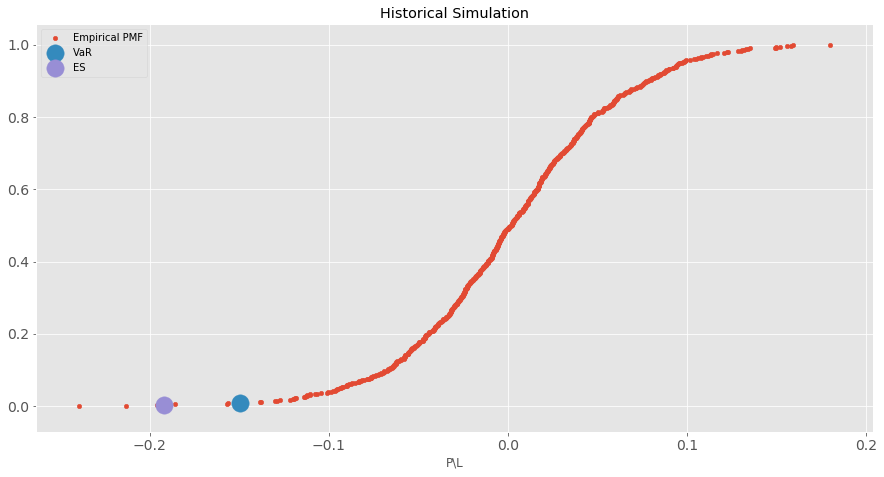

In [115]:
VaR_hist, ES_hist = historical_stock_VaR_ES(start, end, p_weights, alpha, plot = True)

print(f'VaR: C вероятностью {1-alpha} портфель не потеряет за 10-дневный срок больше чем {round(VaR_hist * 100, 2)}% стоимости')
print(f'ES: Если портфель за 10 дней будет терять больше, чем {round(VaR_hist * 100, 2)}% стоимости, то он в среднем потеряет {round(ES_hist*100, 2)}%')

# 4. VaR и ES для облигаций

# 5. Учет валютного риска

# 6. Backtesting

## Подпортфель акций

Найдем доходности портфеля, на которых будем проводить бэктестинг.

In [13]:
last_250_p_returns = (daily_log_returns@p_weights.T)[-251:]

In [100]:
last_250_p_returns.head()

Date
2011-07-01    0.019177
2011-07-04   -0.004745
2011-07-05   -0.004574
2011-07-06   -0.011256
2011-07-07    0.007289
dtype: float64

### Дельта-нормальный метод

In [104]:
p_weights = np.array([0.1, 0.1, 0.1, 0.1, 0.175, 0.175, 0.125, 0.125])
return_period = 10
alpha = 0.01

VaR_delta_norm_backtesting = [ -delta_norm_stock_VaR_ES(daily_log_returns.index[i], daily_log_returns.index[504 + i], 
                               p_weights, alpha, return_period = 10)[0] for i in range(251)];

VaR_delta_norm_backtesting = pd.Series(VaR_delta_norm_backtesting, pd.to_datetime(last_250_p_returns.index))

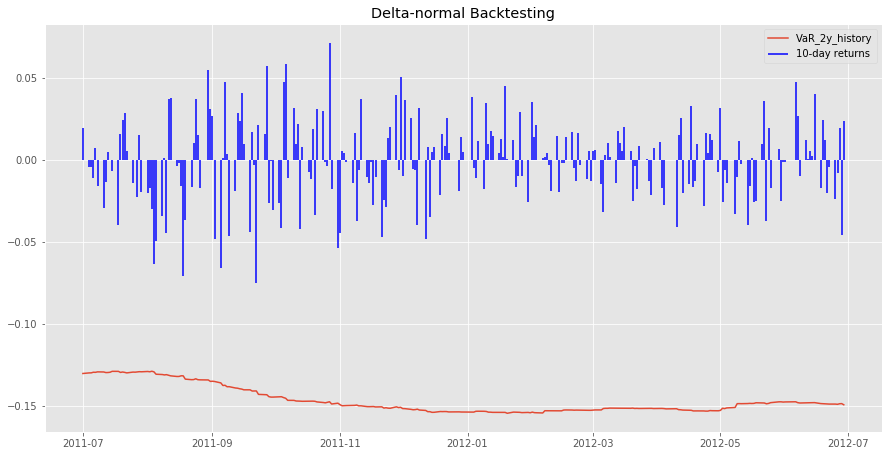

In [105]:
plt.figure(figsize=(15,7.5))

plt.plot(VaR_delta_norm_backtesting);
plt.vlines(last_250_p_returns.index, ymax=list(last_250_p_returns), ymin = 0, colors='b')
plt.legend(['VaR_2y_history', '10-day returns'])
plt.title('Delta-normal Backtesting');

In [ ]:
plt.figure(figsize=(15,7.5))

plt.plot(VaR_delta_norm_backtesting);
plt.vlines(last_250_p_returns.index, ymax=list(last_250_p_returns), ymin = 0, colors='b')
plt.legend(['VaR_2y_history', '10-day returns'])
plt.title('Delta-normal Backtesting');

### Historical simulation

In [116]:
p_weights = np.array([0.1, 0.1, 0.1, 0.1, 0.175, 0.175, 0.125, 0.125])
alpha = 0.01

VaR_historical_backtesting = [ -historical_stock_VaR_ES(day_10_returns.index[i], day_10_returns.index[496 + i], 
                               p_weights, alpha)[0] for i in range(251)];

VaR_historical_backtesting = pd.Series(VaR_historical_backtesting, pd.to_datetime(last_250_p_returns.index))

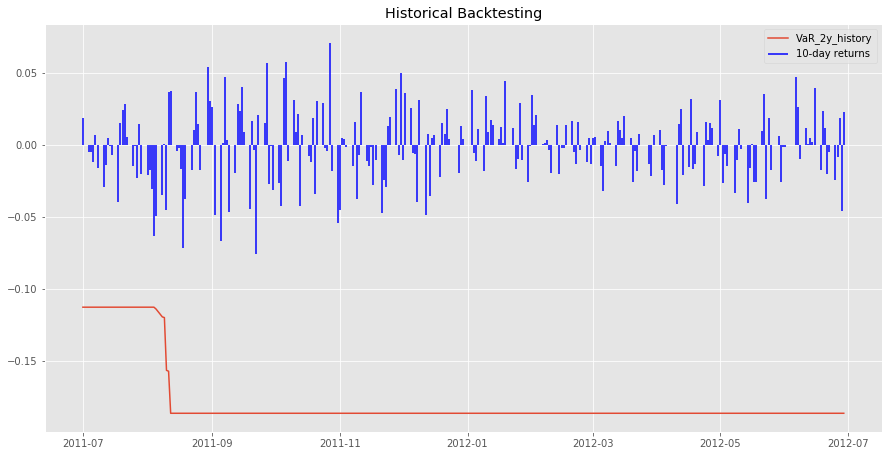

In [119]:
plt.figure(figsize=(15,7.5))

plt.plot(VaR_historical_backtesting);
plt.vlines(last_250_p_returns.index, ymax=list(last_250_p_returns), ymin = 0, colors='b')
plt.legend(['VaR_2y_history', '10-day returns'])
plt.title('Historical Backtesting');

## 7. Задача c лимитом

Задача не еще решена.

Ниже просто пример нахождения оптимальных весов в портфеле акций.

In [126]:
from scipy.optimize import minimize

In [124]:
w = p_weights

In [210]:
def loss(w, returns = daily_log_returns):
    cov = np.array(returns.cov())
    return w@cov@w

cons = ({'type': 'eq', 'fun' : lambda w: np.sum(w) - 1.0},
        {'type': 'ineq', 'fun' : lambda w: w[0]},
        {'type': 'ineq', 'fun' : lambda w: w[1]},
        {'type': 'ineq', 'fun' : lambda w: w[2]},
        {'type': 'ineq', 'fun' : lambda w: w[3]},
        {'type': 'ineq', 'fun' : lambda w: w[4]},
        {'type': 'ineq', 'fun' : lambda w: w[5]},
        {'type': 'ineq', 'fun' : lambda w: w[6]},
        {'type': 'ineq', 'fun' : lambda w: w[7]})

w0 = np.random.rand(w.shape[0])
res = minimize(loss, w0, method='BFGS', constraints=cons,
               bounds=[(0, np.inf) for i in range(w.shape[0])], options={'disp': True},)

print(res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 47
         Function evaluations: 540
         Gradient evaluations: 54
[ 0.02601272 -0.0015419   0.01767541  0.00036154 -0.00626559  0.00848308
 -0.01748644 -0.02708989]
